# Clustering and Classification of MEPs' Tweets

This project has the purpose of applying machine learning techniques (clustering and classification) to a number of tweets obtained from [Cohesion and Coalition Formation in the European Parliament: Roll-Call Votes and Twitter Activities](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0166586). It is comprised of tweets made by Members of the European Parliament.

This project is based on an original assignment by Ioannis Pavlopoulos (postdoc researcher) and Vasiliki Kougia (PhD candidate at AUEB).

## Data Preparation

We will be using the `retweets.csv` file from <https://www.clarin.si/repository/xmlui/handle/11356/1071>.
We will use the text from the original english tweets from the dataset, which we will download using the Tweepy API.
Lastly, we will keep only the MEP groups that had more than 50 tweets.

### Importing the usual libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Reading
We check if we have already saved a file with the text from the tweets and read it.

In [79]:
import os.path
file_exists = os.path.exists('./retweets_text.csv')
if file_exists:
    retweets = pd.read_csv('retweets_text.csv')

### Getting the data from Twitter using Tweepy

* In order to access the Tweepy features, we need to provide our keys, given to us by Twitter for Developers.
* We read the `retweets.csv` file explained above, limit it to only english tweets and drop the Nan values from the column that has the original tweet id.
* We get the *unique* original tweets ids, which we then turn into a list, so we can provide it to Tweepy. Unique values are kept, because in the dataset some original tweets may be retweeted more than once; there is no need for us to search for them multiple times.
* For batches of 100, we provide Tweepy of a list of ids, which it searches for and returns.
* For every tweet (status), we keep the id and the text.
* Lastly, we go to our original DataFrame and, for every original tweet that we got, we search for it by its id. We then get a number of rows that have this original tweet id, to which we add the text, in a column we named `origTweetText`.

In [80]:
if not file_exists: # we have not saved the tweets' text and need to download it
    import tweepy
    from twitter_config import config

    auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
    auth.set_access_token(config['access_token'], config['access_token_secret'])
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    retweets = pd.read_csv('retweets.csv')
    retweets = retweets.loc[retweets.lang == 'en'].dropna(subset=['origTweetId']).reset_index(drop = True)
    retweets_ids = retweets.origTweetId.unique().tolist()

    statuses = []
    for x in range(0, len(retweets_ids), 100):
        print(x) #show progress
        statuses += api.statuses_lookup(retweets_ids[x:x + 100])

    status_list = [(x.id, x.text) for x in statuses]

    for status in status_list:
        retweets.loc[retweets['origTweetId'] == status[0], 'origTweetText'] = status[1]

#### Checking
We do a simple manual check to see that everything matched properly.

In [81]:
if not file_exists:
    for x in status_list:
        if x[0] in retweets.head().origTweetId.values:
            print(x)

    print(retweets[['origTweetText', 'origTweetId']].head())

#### We make sure that that column doesn't have Nan values

In [82]:
if not file_exists:
    retweets = retweets.dropna(subset=['origTweetText'])

#### Filtering
There are a couple of MEP groups that have less than 50 tweets, we drop them.
Afterwards, we save the DataFrame to a csv, so we dont have to do the above process every time we open the Notebook.

In [83]:
if not file_exists:
    retweets = retweets.groupby(['origMepGroupId']).filter(lambda x: len(x) > 50)

    retweets.to_csv('retweets_text.csv', encoding='utf-8', index=False)

## Clustering

* We will be using the K-Means algorithm to cluster the text of the tweets.
* In order to do so, we will use CountVectorizer and TfidfVectorizer.
* We will convert to lowercase and strip the english stopwords from the text, together with some popular European Parliament lingo and some additional words that add no value to the clustering.
* We will limit the words by using `min_df=10` and `max_df=0.50`.
* For the tokenization, we will use a regex that removes urls and the `&amp` and keeps words with a minimum of three letters.<br><br>
*Note*: the below clustering results seem to change slightly if run again, due to the low clustering quality we get.

#### Tweets' text sampling
We check our tweets' text to see how they look.
* A couple of things we notice is that there are some `t.co` urls. From twitter: `Twitter uses the t.co domain as part of a service to protect users from harmful activity, to provide value for the developer ecosystem, and as a quality signal for surfacing relevant, interesting Tweets.`. So let us remove them.
* Secondly, there are &amp keywords for the `&` character. Removing them too.
* Also, we are lucky, since twitter has a limit of characters, so the text is more dense, with less stopwords, which will help us yeild better results.

In [84]:
pd.options.display.max_colwidth = 300
retweets.sample(10, random_state=42)['origTweetText'].values

array(['This afternoon, thousands in Barcelona in solidarity with refugees. #refugeeswelcome #RefugiadosBienvenidos http://t.co/ZNNBxVK70w',
       'Key votes on #refugeecrisis in EuroParl today. #Farage  seat empty. #Ukip rhetoric in debate, not bovvered to vote! http://t.co/Fd1U0bZRgw',
       'Estimated number of ISIS fighters per country\nper million people https://t.co/fI0b2SaB65',
       '#Venezuela Assassination of L M Diaz is an additional reason to send a @Europarl_EN observation mission to elections on Dec 6th @EPPGroup',
       "#Endowment for #Democracy achieved excellent results during it's two years of activities.  Fight for democracy is on! http://t.co/H9OCOJYDjp",
       'Ensaf #Haider, wife of #SakharovPrize winner Raif #Badawi, is speaking to @EPPGroup. We strongly stand behind you! https://t.co/zhEUt8OcWm',
       'Confratulations to @ALDEgroup colleague @TonyGuoga as well #politico28 https://t.co/1B51gv1Bsr',
       'EU must help the North African countries with mon

#### Utilising regex and apply
* We use a regex to do the necessary cleaning.
* We can see that everything worked properly.
* We will leave the tokenization up to the Vectorizers.

In [115]:
import re
def clean_string(string, tokenize=False):
    x = re.sub(r'(\&amp|https?://\S+)', '', string)
    if tokenize:
        x = re.findall(r'(\b[a-zA-Z]{3,}\b)', x)
    return x

retweets.loc[:, 'origTweetText'] = retweets.loc[:, 'origTweetText'].apply(clean_string)

retweets.sample(10, random_state=42)['origTweetText'].values

array(['inspiring role models on the scene @kvanbrempt and @LauraSlimani, lovely room, look forward to the discussions #prog4climate',
       'UKIP will lead the ground campaign. We will play our part in this No campaign. #HowNoCanWin',
       'Great to meet @bryworthington today w @SebDance: knowledge, passion ; conviction @labourenergy @TheProgressives @EuroLabour @UKLabour',
       'My column today in the Journal along with an amusing juxtaposition .... ',
       '#Sefcovic commits to having CO2 allowances for heavy EU industry to keep jobs in Europe (carbon leakage) #EPhearings2014',
       '‘Arts, culture and creativity define us...Non mihi. Non tibi. Sed nobis. Not for me. Not for you. But for us.’ \n',
       'Vote on meat labelling today, I have continued to stand up for consumers who need to be heard above lobbyists. \n ',
       'I support every campaign that wants to get the UK out of the EU.\n',
       'The newest addition to the Sinn Féin propaganda arsenal has arrived. In

#### Tokenization glimpse

In [116]:
retweets.sample(10, random_state=42)['origTweetText'].apply(clean_string, tokenize=True)

10378                    [inspiring, role, models, the, scene, kvanbrempt, and, LauraSlimani, lovely, room, look, forward, the, discussions]
8161                                           [UKIP, will, lead, the, ground, campaign, will, play, our, part, this, campaign, HowNoCanWin]
2624     [Great, meet, bryworthington, today, SebDance, knowledge, passion, conviction, labourenergy, TheProgressives, EuroLabour, UKLabour]
6768                                                                      [column, today, the, Journal, along, with, amusing, juxtaposition]
344                                       [Sefcovic, commits, having, allowances, for, heavy, industry, keep, jobs, Europe, carbon, leakage]
5398                           [Arts, culture, and, creativity, define, Non, mihi, Non, tibi, Sed, nobis, Not, for, Not, for, you, But, for]
3130                              [Vote, meat, labelling, today, have, continued, stand, for, consumers, who, need, heard, above, lobbyists]
9956         

In [87]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

words = text.ENGLISH_STOP_WORDS.union(['today', 'vote', 'just', 'good', 'new', 'europe',
                                       'european', 'need', 'says', 'apply', 'make', 'come',
                                       'here', 'for', 'with', 'the', 'and'])

c_vect = CountVectorizer(strip_accents='unicode',
                         lowercase=True,
                         max_df=0.50, 
                         min_df=10,
                         token_pattern = r'(\b[a-zA-Z]{3,}\b)',
                         stop_words=words)

tfidf_vect = TfidfVectorizer(strip_accents='unicode',
                             lowercase=True,
                             max_df=0.50, 
                             min_df=10,
                             token_pattern = r'(\b[a-zA-Z]{3,}\b)',
                             stop_words=words)

### Keep only the unique tweets and fit + transform the Vectorizers

In [88]:
retweets = retweets.drop_duplicates(subset = ['origTweetText'])
tfidf_transformed = tfidf_vect.fit_transform(retweets['origTweetText'])
c_transformed = c_vect.fit_transform(retweets['origTweetText'])

### Elbow and Silhouette Visualizer
In order to decide which number of clusters is the best, we will use the Elbow and Silhouette Visualizers, so we can cross-check the results with both.

*Note*: The clustering did not seem to fare well at all, so we increased the `n_init` and `max_iter` number, to give it a bit more room to find better clusters.

#### Tfidf Elbow Visualizer
For the cluster number between 2 and 13, let us see which is the optimal number, according to the Elbow Visualizer, for the text that is transformed with the Tfidf algorithm.

We can see that the results we are getting are not good. We won't even bother picking one.

C:\Users\Nick\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Nick\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


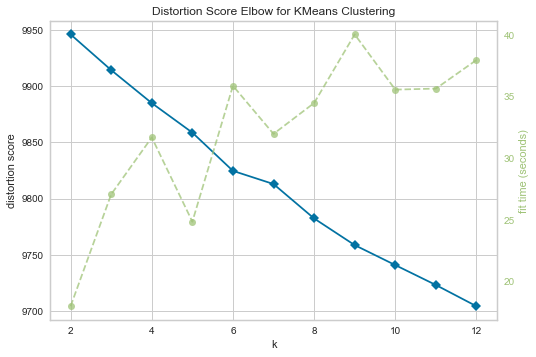

In [89]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(n_jobs=-1, n_init=25, max_iter=400)
visualizer = KElbowVisualizer(kmeans, k=(2,13))

visualizer.fit(tfidf_transformed)
visualizer.show()

#### Tfidf Silhouette Visualizer
For the cluster number between 2 and 13, let us see which is the optimal number, according to the Silhouette Visualizer, for the text that is transformed with the Tfidf algorithm.

Every score is less than 0.012, which again is not good at all.

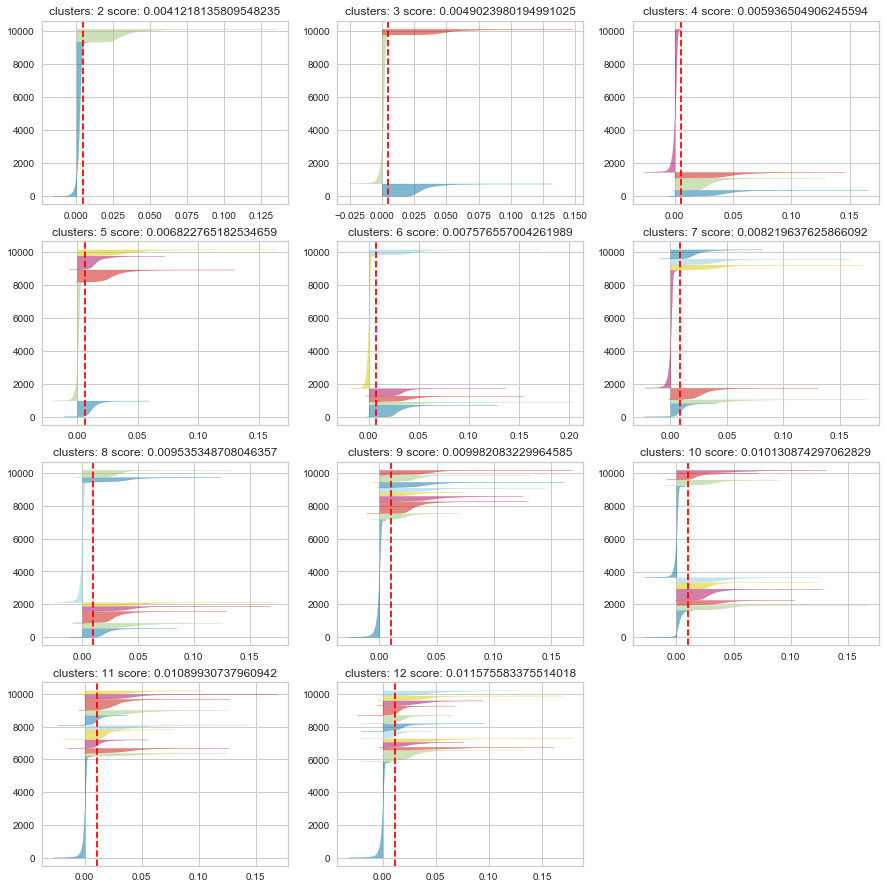

In [90]:
# adopted from the course's slides
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(3 * 5,  12 * 4))

for n_clusters in range(2, 13):

    plt.subplot(12, 3, n_clusters - 1)
    kmeans_sil = KMeans(n_clusters, n_jobs=-1, n_init=25, max_iter=400)
    
    visualizer = SilhouetteVisualizer(kmeans_sil, colors='yellowbrick')
    visualizer.fit(tfidf_transformed)
    
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

#### Count Elbow Visualizer
Let us use again the Elbow Visualizer, for the text that is transformed with the Count Vectorizer.

The results seem to be a bit better than the Tfidf algorithm. We get an `elbow`, at 9 clusters.

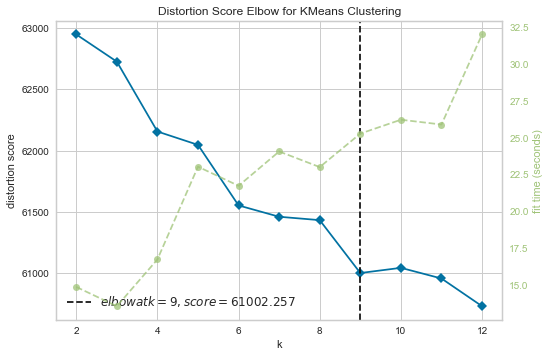

In [91]:
visualizer = KElbowVisualizer(kmeans, k=(2,13))

visualizer.fit(c_transformed)
visualizer.show()

#### Count Silhouette Visualizer
Continuing with the Silhouette Visualizer, for the text that is transformed with the Count Vectorizer.

Best number seems to be for 2 clusters, closely followed by the score of 5 clusters. We will pick 5 clusters, since they have a better distortion score than 2, and a relatively good silhouette score.

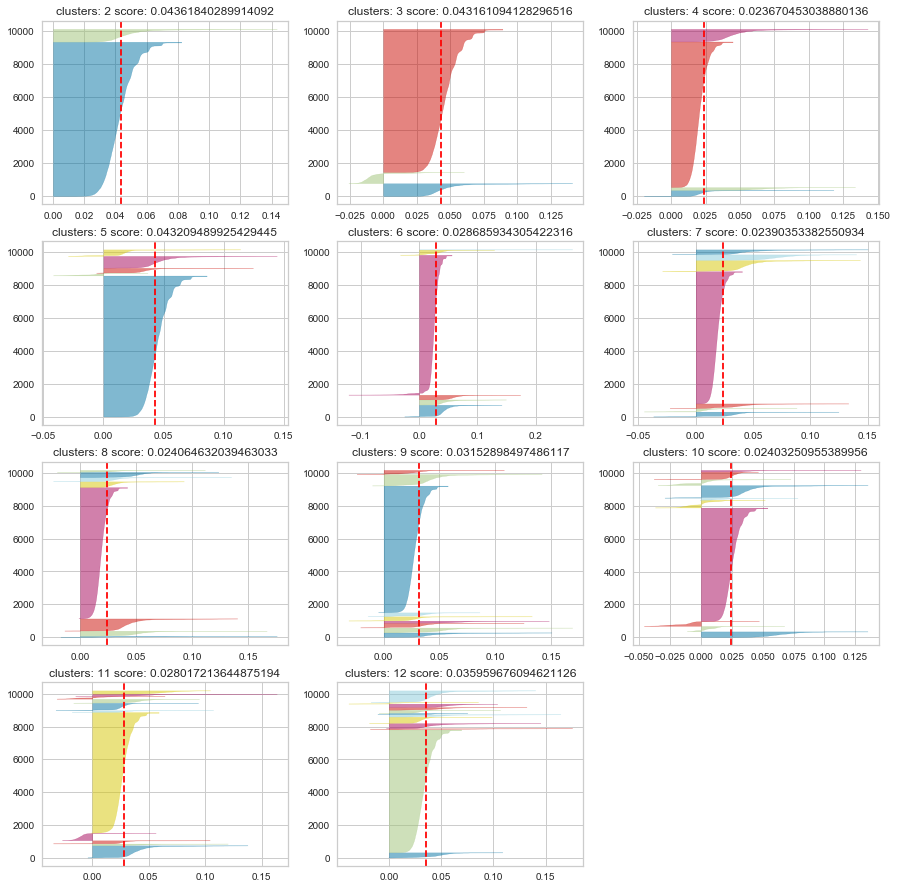

In [92]:
plt.figure(figsize=(3 * 5,  12 * 4))

for n_clusters in range(2, 13):

    plt.subplot(12, 3, n_clusters - 1)
    kmeans_sil = KMeans(n_clusters, n_jobs=-1, n_init=25, max_iter=400)
    
    visualizer = SilhouetteVisualizer(kmeans_sil, colors='yellowbrick')
    visualizer.fit(c_transformed)
    
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

#### Utilising bi-grams
The results we got are not that good, so let us try to see if bi-grams will improve the situation.

In [93]:
c_vect_bi = CountVectorizer(strip_accents='unicode',
                         lowercase=True,
                         max_df=0.50, 
                         min_df=10,
                         token_pattern = r'(\b[a-zA-Z]{3,}\b)',
                         stop_words=words,
                         ngram_range=(1,2))

c_transformed_bi = c_vect_bi.fit_transform(retweets['origTweetText'])

#### Elbow Visualizer
We can find an `elbow` at 7 clusters.

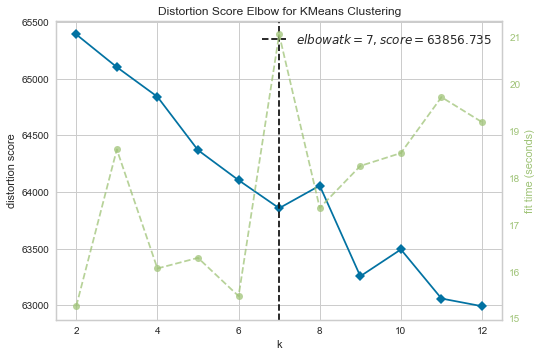

In [94]:
visualizer = KElbowVisualizer(kmeans, k=(2,13))

visualizer.fit(c_transformed_bi)
visualizer.show()

#### Silhouette Visualizer
We can see that with bi-grams, the elbow and silhouette visualizer seem to agree than 7 clusters are a good number. We will go with that.

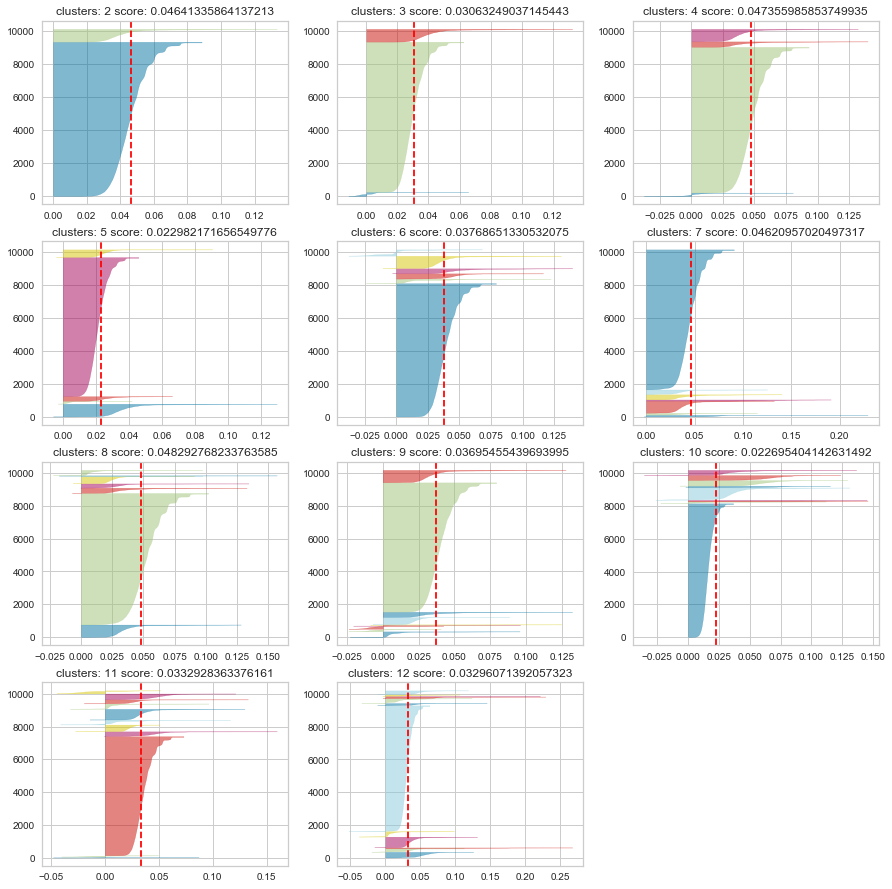

In [95]:
plt.figure(figsize=(3 * 5,  12 * 4))

for n_clusters in range(2, 13):

    plt.subplot(12, 3, n_clusters - 1)
    kmeans_sil = KMeans(n_clusters, n_jobs=-1, n_init=25, max_iter=400)
    
    visualizer = SilhouetteVisualizer(kmeans_sil, colors='yellowbrick')
    visualizer.fit(c_transformed_bi)
    
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

#### Visualizing cluster distance
We settled on 7 clusters, so let's see how they look in a two dimensional space.

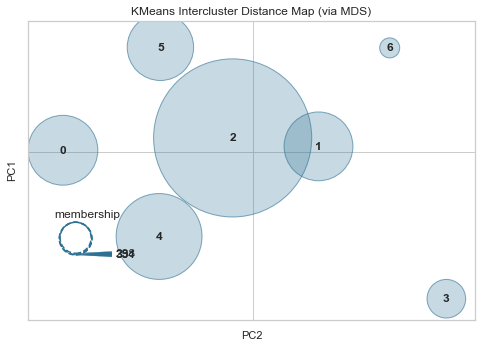

In [96]:
from yellowbrick.cluster import InterclusterDistance

kmeans_final = KMeans(7, n_init=25, max_iter=400)
visualizer = InterclusterDistance(kmeans_final)

visualizer.fit(c_transformed_bi)
visualizer.show() 

#### Top terms per cluster
To get an idea of the contents of the clusters, we will show the top 20 terms from each.

We do not see any clear differentiation between them.
* The first one seems to include young people and the refugee crisis in Greece.
* The second one seems a bit clearer, with David Cameron and the 2016 British referendum.
* The fourth one seems to be from mostly British MEPs.
* The last one seems to be talking about investments and crises.<br><br>
Overall, it is the best clustering we can get, but not good enough.

In [98]:
print("Top terms per cluster:")
order_centroids = kmeans_final.cluster_centers_.argsort()[:, ::-1]
terms = c_vect_bi.get_feature_names()

columns = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']

order_centroids_names = [['' for i in range(7)] for j in range(20)]

for i in range(7):
    for x, ind in enumerate(order_centroids[i, :20]):
        order_centroids_names[x][i] = terms[ind]

cluster_terms = pd.DataFrame(order_centroids_names, columns=columns)
cluster_terms

Top terms per cluster:


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
0,people,cameron,eppgroup,states,ukip,debate,long
1,young,time,great,member,labour,ttip,term
2,young people,david,ttip,member states,party,ukip,long term
3,want,david cameron,meeting,eppgroup,nhs,live,investment
4,greek,renegotiation,meps,refugees,people,parliament,term investment
5,greek people,migration,support,sharing,policy,digital,intergroup
6,british,support,parliament,tax,immigration,mep,time
7,eppgroup,referendum,labour,junckereu,meps,tonight,start
8,british people,reform,greece,action,tories,meps,support
9,greece,wants,work,investment,lab,follow,night


#### Reducing the dimensions
As we can see above, the clusters we formed do not adequately separate our data. It is expected, since the K-Means algorithm does not handle thousands of features well. In order to see if we improve the results, let us limit the features to 300 with the SVD algorithm, since it seems that it is the best algorithm for this job.

As we can see the algorithm explaines around 54% of the variance. We would probably go with 8 or 9 clusters.

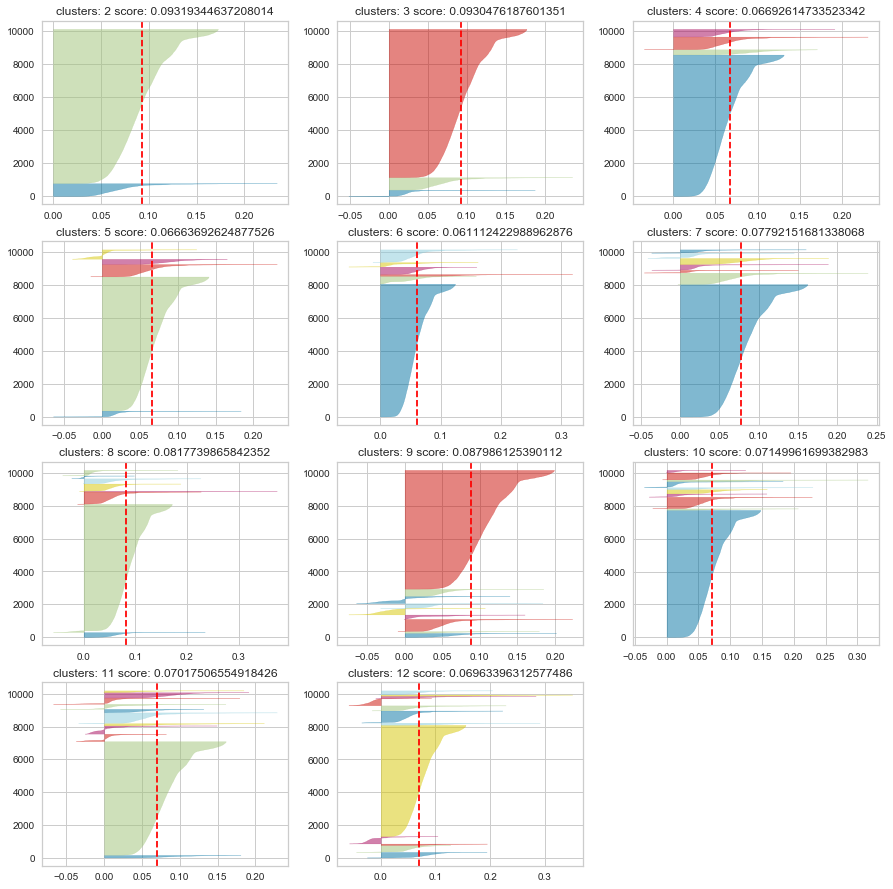

In [121]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, n_iter=100, random_state=42)
svd_transformed = svd.fit_transform(c_transformed_bi)

plt.figure(figsize=(3 * 5,  12 * 4))

for n_clusters in range(2, 13):

    plt.subplot(12, 3, n_clusters - 1)
    kmeans_sil = KMeans(n_clusters, n_jobs=-1, n_init=25, max_iter=400)
    
    visualizer = SilhouetteVisualizer(kmeans_sil, colors='yellowbrick')
    visualizer.fit(svd_transformed)
    
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [122]:
print(svd.explained_variance_ratio_.sum())

0.5360898388461237


## Classification

Let us try to form two classification models that can predict the political MEP group from the tweet's text.

* We split the data into training and testing groups.
* We will use Multinomial Naive Bayes and Random Forest Classifier algorithms, since most online sources tell us that these are good algorithms to try for text classification.
* We will use pipelines, with cross-validation and grid search, to find the best parameters to use in the algorithms.

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

text = retweets.origTweetText
target = retweets.origMepGroupId
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=0.25)

#### Tfidf and Naive Bayes

Ideally, we would try all of the parameters in the grid search, but realistically, that is not feasible in a reasonable amount of time, with an old laptop. Thus, we will limit the hyperparameters and explicitly use some of the parameters that we used in clustering, like the stopwords and the token pattern.


In [104]:
text_clf_tfidf_nb = Pipeline([('vect', CountVectorizer(strip_accents='unicode',
                                                       lowercase=True,
                                                       token_pattern = r'(\b[a-zA-Z]{3,}\b)',
                                                       stop_words=words)),
                             ('tfidf', TfidfTransformer()),
                             ('clf', MultinomialNB()),
                             ])

text_clf_tfidf_nb.fit(X_train, y_train)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [0.40, 0.50, 0.90],
              'vect__min_df': [5, 15],
              'tfidf__use_idf': [True, False],
              'clf__alpha': [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
             }

gs_clf_tfifd_nb = GridSearchCV(text_clf_tfidf_nb, parameters, n_jobs=-1, cv=5, scoring='accuracy')

gs_clf_tfidf_nb = gs_clf_tfifd_nb.fit(X_train, y_train)

#### Tfidf Naive Bayes results
We can see that we got a good enough classification algorithm. We got an accuracy of around 58% and the rest of the scoring indicators (precision, recall and f1-score) seem to be at the same level. Cross Validation scores are at 54%.

In [105]:
y_pred = gs_clf_tfidf_nb.predict(X_test)

print(classification_report(y_test, y_pred))

print(gs_clf_tfidf_nb.best_params_)
print(gs_clf_tfidf_nb.score(X_test, y_test))
gs_clf_tfidf_nb.cv_results_['mean_test_score'].mean()

              precision    recall  f1-score   support

           0       0.72      0.23      0.35        78
           1       0.55      0.66      0.60       582
           2       0.51      0.35      0.42       236
           3       0.46      0.47      0.47       352
           4       0.56      0.59      0.58       392
           5       0.56      0.28      0.37       270
           6       0.69      0.82      0.75       615

    accuracy                           0.58      2525
   macro avg       0.58      0.49      0.50      2525
weighted avg       0.58      0.58      0.57      2525

{'clf__alpha': 0.05, 'tfidf__use_idf': False, 'vect__max_df': 0.4, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
0.5798019801980198


0.5391404805914972

#### Count Vectorizer and Naive Bayes
Let us see if we get better results without the Tfidf Transformation.

In [238]:
text_clf_count_nb = Pipeline([('vect', CountVectorizer(stop_words=words)),
                             ('clf', MultinomialNB()),
                             ])

text_clf_count_nb.fit(X_train, y_train)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [0.40, 0.50, 0.80],
              'vect__min_df': [3, 5, 15],
              'vect__strip_accents': ['unicode', None],
              'vect__lowercase': [True, False],
              'vect__token_pattern': [r'(\b[a-zA-Z]{3,}\b)', r'(\b[a-zA-Z]{4,}\b)'],
              'clf__alpha': [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
             }

gs_clf_count_nb = GridSearchCV(text_clf_count_nb, parameters, n_jobs=-1, cv=5, scoring='accuracy', verbose=5)

gs_clf_count_nb = gs_clf_count_nb.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | el

#### Count Naive Bayes results

We increased the Count Vectorizer possible parameters, since Naive Bayes only has one, and the number of fits stays low.

Results remain almost the same.

In [239]:
y_pred = gs_clf_count_nb.predict(X_test)

print(classification_report(y_test, y_pred))

print(gs_clf_count_nb.best_params_)
print(gs_clf_count_nb.score(X_test, y_test))
gs_clf_count_nb.cv_results_['mean_test_score'].mean()

              precision    recall  f1-score   support

           0       0.50      0.56      0.53        63
           1       0.62      0.59      0.60       600
           2       0.39      0.36      0.38       235
           3       0.50      0.49      0.49       391
           4       0.59      0.61      0.60       400
           5       0.42      0.40      0.41       243
           6       0.73      0.78      0.75       593

    accuracy                           0.58      2525
   macro avg       0.53      0.54      0.54      2525
weighted avg       0.58      0.58      0.58      2525

{'clf__alpha': 0.1, 'vect__lowercase': True, 'vect__max_df': 0.4, 'vect__min_df': 3, 'vect__ngram_range': (1, 2), 'vect__strip_accents': 'unicode', 'vect__token_pattern': '(\\b[a-zA-Z]{3,}\\b)'}
0.5817821782178217


0.5364454053340375

#### Random Forest
The second classifier we will use is the Random Forest Classifier. We start without the Tfidf transformation.

In [108]:
text_clf_count_rf = Pipeline([('vect', CountVectorizer(strip_accents='unicode',
                                                       lowercase=True,
                                                       token_pattern = r'(\b[a-zA-Z]{3,}\b)',
                                                       stop_words=words)),
                             ('rf', RandomForestClassifier()),
                             ])

text_clf_count_rf.fit(X_train, y_train)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [0.4, 0.5, 0.8],
              'vect__min_df': [5, 15],
              'rf__max_depth': [100, 500, 1000, None],
              'rf__n_estimators': [50, 150, 300],
              'rf__min_samples_split': [100, 500, 700],
             }

gs_clf_count_rf = GridSearchCV(text_clf_count_rf, parameters, n_jobs=-1, cv=5, scoring='accuracy', verbose=5)

gs_clf_count_rf = gs_clf_count_rf.fit(X_train, y_train)

C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 41.5min finished


#### Results
With 41' of Grid Search we would expect a better result. But it dropped to 53% cross-validating score.

In [109]:
y_pred = gs_clf_count_rf.predict(X_test)

print(classification_report(y_test, y_pred))

print(gs_clf_count_rf.best_params_)
print(gs_clf_count_rf.score(X_test, y_test))
gs_clf_count_rf.cv_results_['mean_test_score'].mean()

              precision    recall  f1-score   support

           0       0.64      0.36      0.46        78
           1       0.47      0.68      0.56       582
           2       0.58      0.32      0.41       236
           3       0.50      0.40      0.45       352
           4       0.61      0.60      0.61       392
           5       0.63      0.26      0.37       270
           6       0.65      0.78      0.71       615

    accuracy                           0.57      2525
   macro avg       0.58      0.49      0.51      2525
weighted avg       0.57      0.57      0.55      2525

{'rf__max_depth': 1000, 'rf__min_samples_split': 500, 'rf__n_estimators': 300, 'vect__max_df': 0.4, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
0.5651485148514851


0.5338854169722931

#### Including the Tfidf

In [110]:
text_clf_tfidf_rf = Pipeline([('vect', CountVectorizer(lowercase=True,
                                                       token_pattern = r'(\b[a-zA-Z]{3,}\b)',
                                                       stop_words=words)),
                              ('tfidf', TfidfTransformer()),
                              ('rf', RandomForestClassifier()),
                              ])

text_clf_tfidf_rf.fit(X_train, y_train)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [0.5, 0.8],
              'vect__min_df': [5, 15],
              'vect__strip_accents': ['unicode', None],
              'tfidf__use_idf': [True, False],
              'rf__max_depth': [100, 500, 1000, None],
              'rf__n_estimators': [150, 300],
              'rf__min_samples_split': [100, 300, 500],
             }

gs_clf_tfidf_rf = GridSearchCV(text_clf_tfidf_rf, parameters, n_jobs=-1, cv=4, scoring='accuracy', verbose=5)

gs_clf_tfidf_rf = gs_clf_tfidf_rf.fit(X_train, y_train)

C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting 4 folds for each of 768 candidates, totalling 3072 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 69.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 86.0min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 100.8min
[Parallel(n_jobs=-1)]: Done 3072 out of 3072 | elapsed: 102.2min finished


#### We get a slight decrease

In [111]:
y_pred = gs_clf_tfidf_rf.predict(X_test)

print(classification_report(y_test, y_pred))

print(gs_clf_tfidf_rf.best_params_)
print(gs_clf_tfidf_rf.score(X_test, y_test))
gs_clf_tfidf_rf.cv_results_['mean_test_score'].mean()

              precision    recall  f1-score   support

           0       0.64      0.35      0.45        78
           1       0.47      0.67      0.55       582
           2       0.57      0.29      0.38       236
           3       0.49      0.43      0.46       352
           4       0.60      0.60      0.60       392
           5       0.59      0.24      0.34       270
           6       0.65      0.77      0.70       615

    accuracy                           0.56      2525
   macro avg       0.57      0.48      0.50      2525
weighted avg       0.56      0.56      0.54      2525

{'rf__max_depth': 1000, 'rf__min_samples_split': 500, 'rf__n_estimators': 300, 'tfidf__use_idf': True, 'vect__max_df': 0.8, 'vect__min_df': 5, 'vect__ngram_range': (1, 2), 'vect__strip_accents': 'unicode'}
0.5576237623762377


0.5283418878179739

#### Classification for dummies
To see if we did something that is worth our effort, let us try the Dummy Classifier, as a baseline.

We see that we get an accuracy of 18%, which is around 50% less than what we got above, so our models seem to be good enough.

*Note*: We do not really need to transform the data for the Dummy Classifier. It just looks at labels. However, the code to do so can be found commented out, below.

In [112]:
from sklearn.dummy import DummyClassifier

#c_vect_dummy = CountVectorizer(strip_accents='unicode',
#                         lowercase=True,
#                         max_df=0.50, 
#                         min_df=10,
#                         token_pattern = r'(\b[a-zA-Z]{3,}\b)',
#                         stop_words=words)

#c_transformed_train = c_vect_dummy.fit_transform(X_train)

dummy_clf = DummyClassifier()
#dummy_clf.fit(c_transformed_train, y_train)

dummy_clf.fit(X_train, y_train)
#c_transformed_test = c_vect_dummy.transform(X_test)

#y_pred = dummy_clf.predict(c_transformed_test)
y_pred = dummy_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.20      0.21      0.21       582
           2       0.10      0.11      0.11       236
           3       0.13      0.14      0.14       352
           4       0.18      0.20      0.19       392
           5       0.12      0.11      0.12       270
           6       0.25      0.23      0.24       615

    accuracy                           0.18      2525
   macro avg       0.14      0.14      0.14      2525
weighted avg       0.18      0.18      0.18      2525



#### SGD
Since we are not that happy with the models above, we will also try SGD classifier.

In [124]:
from sklearn.linear_model import SGDClassifier

text_clf_tfidf_svm = Pipeline([('vect', CountVectorizer(strip_accents='unicode',
                                                        lowercase=True,
                                                        token_pattern = r'(\b[a-zA-Z]{3,}\b)',
                                                        stop_words=words)),
                              ('tfidf', TfidfTransformer()),
                              ('clf', SGDClassifier()),
                              ])

text_clf_tfidf_svm.text_clf_c_svmfit(X_train, y_train)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [0.5, 0.8, 1.0],
              'vect__min_df': [5, 15],
              'tfidf__use_idf': [True, False],
              'clf__alpha': [5e-4, 1e-3, 5e-3, 1e-2],
              'clf__loss': ['hinge', 'log', 'squared_hinge', 'squared_loss'],
              'clf__penalty': ['l2','l1']
             }

gs_clf_tfidf_svm = GridSearchCV(text_clf_tfidf_svm, parameters, n_jobs=-1, cv=4, scoring='accuracy', verbose=5)

gs_clf_tfidf_svm = gs_clf_tfidf_svm.fit(X_train, y_train)

Fitting 4 folds for each of 768 candidates, totalling 3072 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 3072 out of 3072 | elapsed: 13.7min finished


#### Results
It seems that the SGD algorithm is not doing that well. All of our scores decreased.

In [125]:
y_pred = gs_clf_tfidf_svm.predict(X_test)

print(classification_report(y_test, y_pred))

print(gs_clf_tfidf_svm.best_params_)
print(gs_clf_tfidf_svm.score(X_test, y_test))
gs_clf_tfidf_svm.cv_results_['mean_test_score'].mean()

              precision    recall  f1-score   support

           0       0.81      0.32      0.46        78
           1       0.55      0.68      0.61       582
           2       0.54      0.32      0.40       236
           3       0.51      0.47      0.49       352
           4       0.61      0.61      0.61       392
           5       0.59      0.26      0.36       270
           6       0.65      0.84      0.73       615

    accuracy                           0.59      2525
   macro avg       0.61      0.50      0.52      2525
weighted avg       0.59      0.59      0.57      2525

{'clf__alpha': 0.001, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__min_df': 5, 'vect__ngram_range': (1, 1)}
0.5897029702970297


0.45559232241880115

#### Without Tfidf

In [128]:
from sklearn.linear_model import SGDClassifier

text_clf_c_svm = Pipeline([('vect', CountVectorizer(strip_accents='unicode',
                                                        lowercase=True,
                                                        token_pattern = r'(\b[a-zA-Z]{3,}\b)',
                                                        stop_words=words)),
                              ('clf', SGDClassifier()),
                              ])

text_clf_c_svm.fit(X_train, y_train)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [0.5, 0.8, 1.0],
              'vect__min_df': [5, 15],
              'clf__alpha': [5e-4, 1e-3, 5e-3, 1e-2],
              'clf__loss': ['hinge', 'log', 'squared_hinge', 'squared_loss'],
              'clf__penalty': ['l2','l1']
             }

gs_clf_c_svm = GridSearchCV(text_clf_c_svm, parameters, n_jobs=-1, cv=4, scoring='accuracy', verbose=5)

gs_clf_c_svm = gs_clf_c_svm.fit(X_train, y_train)

Fitting 4 folds for each of 384 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed: 26.9min finished


#### Results
The results decreased even further without the Tfidf transformation.

In [129]:
y_pred = gs_clf_c_svm.predict(X_test)

print(classification_report(y_test, y_pred))

print(gs_clf_c_svm.best_params_)
print(gs_clf_c_svm.score(X_test, y_test))
gs_clf_c_svm.cv_results_['mean_test_score'].mean()

              precision    recall  f1-score   support

           0       0.57      0.33      0.42        78
           1       0.59      0.61      0.60       582
           2       0.44      0.36      0.40       236
           3       0.47      0.44      0.45       352
           4       0.60      0.62      0.61       392
           5       0.51      0.32      0.39       270
           6       0.65      0.80      0.72       615

    accuracy                           0.57      2525
   macro avg       0.54      0.50      0.51      2525
weighted avg       0.56      0.57      0.56      2525

{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'clf__penalty': 'l2', 'vect__max_df': 1.0, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
0.5734653465346534


0.39445663894023414

#### Lemmatization
Maybe lemmatization will increase the accuracy.

In [208]:
import nltk
from nltk.stem import WordNetLemmatizer

#nltk.download('wordnet')
def lemmatize(string):
    wnl = WordNetLemmatizer()
    tokens = re.findall(r'(\b[a-zA-Z]{3,}\b)', string)
    lemmatized = []
    for word in tokens:
        lemmatized.append(wnl.lemmatize(word))
    str = ""  
    for ele in lemmatized:  
        str += ' ' + ele   
    return str

In [209]:
retweets.sample(10, random_state=42)['origTweetText'].apply(lemmatize)

10378                         inspiring role model the scene kvanbrempt and LauraSlimani lovely room look forward the discussion
8161                                             UKIP will lead the ground campaign will play our part this campaign HowNoCanWin
2624      Great meet bryworthington today SebDance knowledge passion conviction labourenergy TheProgressives EuroLabour UKLabour
6768                                                                   column today the Journal along with amusing juxtaposition
344                                          Sefcovic commits having allowance for heavy industry keep job Europe carbon leakage
5398                                  Arts culture and creativity define Non mihi Non tibi Sed nobis Not for Not for you But for
3130                                   Vote meat labelling today have continued stand for consumer who need heard above lobbyist
9956                                                                            support every cam

In [211]:
text = retweets.loc[:, 'origTweetText'].apply(lemmatize)
target = retweets.origMepGroupId
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=0.25)

text_clf_count_nb_lemma = Pipeline([('vect', CountVectorizer(strip_accents='unicode',
                                                       lowercase=True,
                                                       stop_words=words)),
                             ('clf', MultinomialNB()),
                             ])

text_clf_count_nb_lemma.fit(X_train, y_train)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [0.40, 0.50, 0.80],
              'vect__min_df': [3, 5, 15],
              'clf__alpha': [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
             }

gs_clf_count_nb_lemma = GridSearchCV(text_clf_count_nb_lemma, parameters, n_jobs=-1, cv=5, scoring='accuracy', verbose=5)

gs_clf_count_nb_lemma = gs_clf_count_nb_lemma.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.4min finished


#### Results
Lemmatization did not increase the accuracy, weirdly.

In [212]:
y_pred = gs_clf_count_nb_lemma.predict(X_test)

print(classification_report(y_test, y_pred))

print(gs_clf_count_nb_lemma.best_params_)
print(gs_clf_count_nb_lemma.score(X_test, y_test))
gs_clf_count_nb_lemma.cv_results_['mean_test_score'].mean()

              precision    recall  f1-score   support

           0       0.49      0.45      0.47        77
           1       0.63      0.60      0.61       596
           2       0.49      0.39      0.43       244
           3       0.48      0.51      0.49       346
           4       0.60      0.63      0.62       405
           5       0.45      0.35      0.39       249
           6       0.70      0.83      0.76       608

    accuracy                           0.60      2525
   macro avg       0.55      0.54      0.54      2525
weighted avg       0.59      0.60      0.59      2525

{'clf__alpha': 0.1, 'vect__max_df': 0.4, 'vect__min_df': 3, 'vect__ngram_range': (1, 1)}
0.596039603960396


0.539314320922454

#### Best model
We tried 3 algorithms with both Tfidf and Count Vectorizer and then tried lemmatizing.
Naive Bayes and Random Forest algorithms seem to fare similarly, with SGD trailing behind.

In [241]:
results_dict = {'Tfidf Naive Bayes': gs_clf_tfidf_nb.cv_results_['mean_test_score'].mean(),
                'Count Naive Bayes': gs_clf_count_nb.cv_results_['mean_test_score'].mean(),
                'Count Random Forest': gs_clf_count_rf.cv_results_['mean_test_score'].mean(),
                'Tfidf Random Forest': gs_clf_tfidf_rf.cv_results_['mean_test_score'].mean(),
                'Tfidf SGD': gs_clf_tfidf_svm.cv_results_['mean_test_score'].mean(),
                'Count SGD': gs_clf_c_svm.cv_results_['mean_test_score'].mean(),
                'Lemmatized Count Naive Bayes': gs_clf_count_nb_lemma.cv_results_['mean_test_score'].mean()}

results = pd.DataFrame(results_dict, index=['Cross_Validation_mean_score']).T.sort_values('Cross_Validation_mean_score', ascending=False)

results

,Cross_Validation_mean_score
Lemmatized Count Naive Bayes,0.539314
Tfidf Naive Bayes,0.539140
Count Naive Bayes,0.536445
Count Random Forest,0.533885
Tfidf Random Forest,0.528342
Tfidf SGD,0.455592
Count SGD,0.394457
